<a href="https://colab.research.google.com/github/basselkassem/easy21/blob/master/Dynamic_Programing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libs

In [1]:
!pip install import_ipynb

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/'Colab Notebooks'/easy21

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/easy21


# Import Libs

In [3]:
import import_ipynb
import environment as env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

importing Jupyter notebook from environment.ipynb


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# MDP Implementation

In [0]:
def check_sanity(proba_dist, name):
    print('Checking sanity for', name)
    assert np.all(proba_dist <= 1.0), 'Values must be less than 1'
    assert np.all(proba_dist >= 0.0), 'Values must be bigger than 0'
    assert np.allclose(np.sum(proba_dist, axis = -1), 1.0), 'Values must sum to 1'
    print('Looks good')

CARD_PROBA = 1 / 10
BLACK_CARD_PROBA = (2 / 3 )* CARD_PROBA
RED_CARD_PROBA = (1 / 3) * CARD_PROBA

def create_player_trans_proba(pdim, ddim):
    trans_proba = np.zeros((pdim , pdim))
    trans_proba[0, 0] = 1
    for i in np.arange(1, 11):
        trans_proba[i, 0] = RED_CARD_PROBA * len(np.arange(i, ddim))
        trans_proba[i, 1: i] = RED_CARD_PROBA
        trans_proba[i, i + 1: i + 11] = BLACK_CARD_PROBA

    for i in np.arange(ddim, pdim):
        trans_proba[i, 0] = BLACK_CARD_PROBA * len(np.arange(pdim - i, ddim))
        trans_proba[i, i - 10: i] = RED_CARD_PROBA
        trans_proba[i, i + 1: i + pdim] = BLACK_CARD_PROBA
    return trans_proba

def create_dealer_trans_proba(pdim, ddim):
    trans_proba = create_player_trans_proba(pdim, ddim)
    trans_proba[17:] = 0
    trans_proba[17:, 17:] = np.eye(5)

    for itr in np.arange(50):
        temp = np.dot(trans_proba, trans_proba)
        diff = np.max(np.abs(temp - trans_proba))
        trans_proba = temp
        if diff < 1e-9:
            break
    return trans_proba

def create_reward_hit(pdim, ddim):
    rewards = np.zeros((pdim, pdim))
    rewards[1:, 0] = -1
    rewards_hit = np.sum(player_trans_proba * rewards, axis= -1)
    rewards_hit = rewards_hit.reshape(-1, 1) + np.zeros((pdim, pdim))
    rewards_hit[:, 0] = 0
    return rewards_hit[:, 0: ddim]

def create_reward_stick(pdim, ddim):
    rewards = []
    for player_score in range(0, pdim):
        winnig_eval = np.zeros((pdim, pdim))
        if player_score != 0:
            winnig_eval[1: 17, :player_score] = 1 # player score > dealer score
            winnig_eval[1: 17, player_score] = 0 # player score = dealer score
            winnig_eval[1: 17, player_score + 1:] = -1 # dealer score > player score
        rewards.append(np.sum(dealer_trans_proba * winnig_eval, axis = -1))
    rewards = np.reshape(rewards, (pdim, pdim))
    return rewards[:, 0: ddim]

def create_MDP(pdim, ddim):
    dealer_trans_stick_proba = np.zeros((ddim, ddim))
    dealer_trans_stick_proba[:, 0] = 1.0
    dealer_trans_stick_proba = dealer_trans_stick_proba.reshape((1, ddim, 1, ddim))

    player_trans_stick_proba = np.eye(pdim).reshape((pdim, 1, pdim, 1))
    trans_stick_proba = player_trans_stick_proba * dealer_trans_stick_proba
    trans_stick_proba = trans_stick_proba.reshape((ddim* pdim, 1, ddim * pdim))

    player_trans_hit_proba = create_player_trans_proba(pdim, ddim).reshape((pdim, 1, pdim, 1))
    dealer_trans_hit_proba = np.eye(ddim).reshape((1, ddim, 1, ddim))
    trans_hit_proba = player_trans_hit_proba * dealer_trans_hit_proba
    trans_hit_proba = trans_hit_proba.reshape((ddim * pdim, 1, ddim * pdim))

    P = np.concatenate([trans_hit_proba, trans_stick_proba], axis = 1)

    rewards_hit = create_reward_hit(pdim, ddim).reshape((ddim * pdim, 1))
    rewards_stick = create_reward_stick(pdim, ddim).reshape((ddim * pdim, 1))
    R = np.concatenate([rewards_hit, rewards_stick], axis = -1)
    
    return P, R

Checking sanity for player score transitions
Looks good


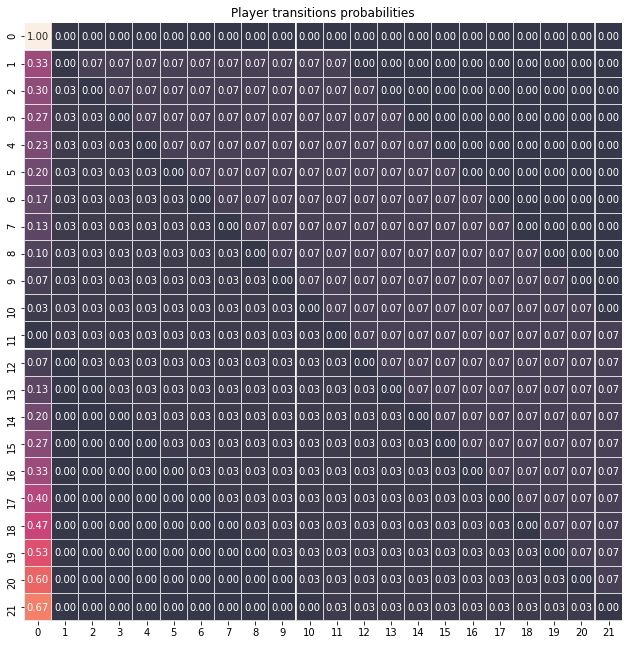

In [5]:
player_trans_proba = create_player_trans_proba(env.MAX_VALUE + 1 , env.CARD_VALUE_MAX + 1)
check_sanity(player_trans_proba, 'player score transitions')
env.Visualizer.draw2d_square_array(player_trans_proba, 'Player transitions probabilities')


Checking sanity for Dealer score transitions
Looks good


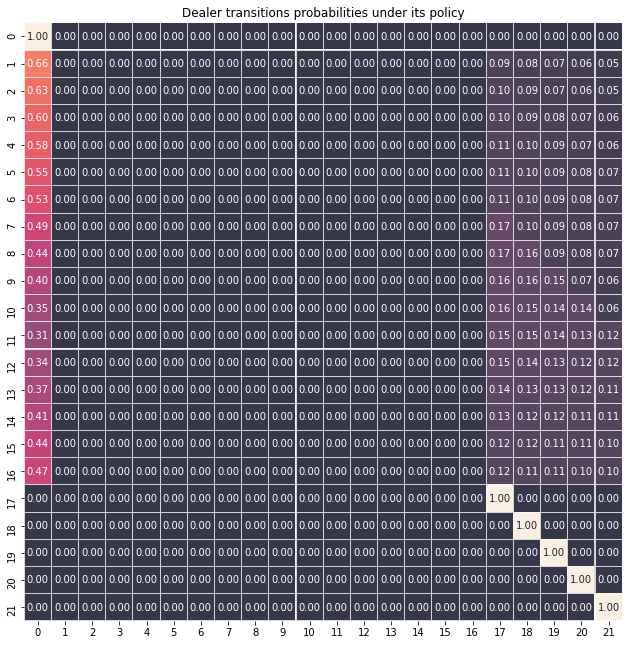

In [6]:
dealer_trans_proba = create_dealer_trans_proba(env.MAX_VALUE + 1 , env.CARD_VALUE_MAX + 1)
check_sanity(dealer_trans_proba, 'Dealer score transitions')
env.Visualizer.draw2d_square_array(dealer_trans_proba, 'Dealer transitions probabilities under its policy')

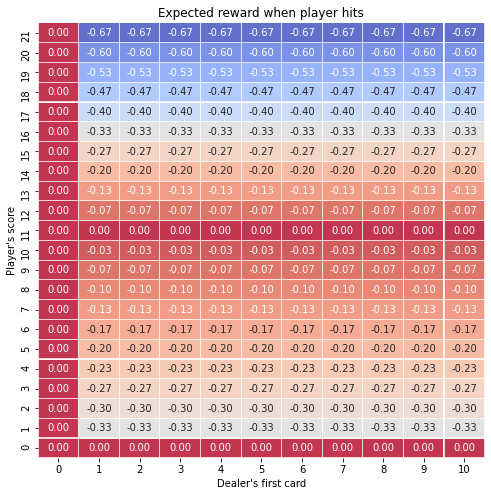

In [7]:
rewards_hit = create_reward_hit(env.MAX_VALUE + 1, env.CARD_VALUE_MAX + 1)
env.Visualizer.draw2d_array(rewards_hit, 'Expected reward when player hits')

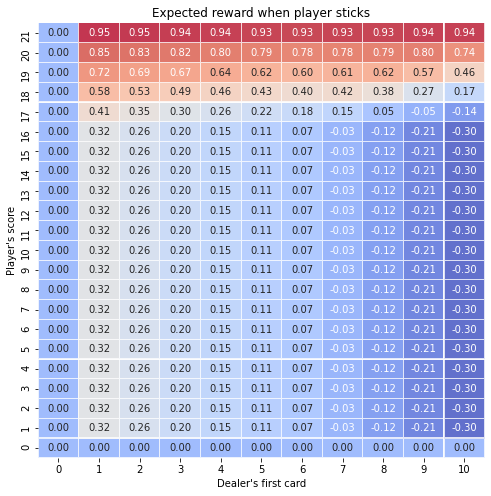

In [8]:
rewards_stick = create_reward_stick(env.MAX_VALUE + 1, env.CARD_VALUE_MAX + 1)
env.Visualizer.draw2d_array(rewards_stick, 'Expected reward when player sticks')

## Combining transition pobabilites and the expected rewards

In [9]:
P, R = create_MDP(env.MAX_VALUE + 1, env.CARD_VALUE_MAX + 1)
print('Expected Rewards', R.shape)
print('Transition probabilites', P.shape)
check_sanity(P, 'Transition probabilites')

Expected Rewards (242, 2)
Transition probabilites (242, 2, 242)
Checking sanity for Transition probabilites
Looks good


# Value Iteration

In [10]:
def value_iteration(pdim, ddim):
    V = np.zeros((pdim * ddim))
    for epoch in range(100):
        temp = np.max(R + np.matmul(P, V),  axis = -1)
        diff = np.max(np.abs(V - temp))
        V = temp
        print('epoch #%d\tvalue_diff: %.7f' %(epoch + 1, diff))
        if diff < 1e-9:
            print('---Converged---')
            break
    return V, V.reshape((pdim, ddim))[1:, 1:]
V_unshaped, V = value_iteration(env.MAX_VALUE + 1, env.CARD_VALUE_MAX + 1)

epoch #1	value_diff: 0.9536395
epoch #2	value_diff: 0.1752320
epoch #3	value_diff: 0.0334339
epoch #4	value_diff: 0.0091116
epoch #5	value_diff: 0.0026771
epoch #6	value_diff: 0.0009157
epoch #7	value_diff: 0.0003060
epoch #8	value_diff: 0.0001103
epoch #9	value_diff: 0.0000475
epoch #10	value_diff: 0.0000205
epoch #11	value_diff: 0.0000088
epoch #12	value_diff: 0.0000038
epoch #13	value_diff: 0.0000016
epoch #14	value_diff: 0.0000007
epoch #15	value_diff: 0.0000003
epoch #16	value_diff: 0.0000001
epoch #17	value_diff: 0.0000001
epoch #18	value_diff: 0.0000000
epoch #19	value_diff: 0.0000000
epoch #20	value_diff: 0.0000000
epoch #21	value_diff: 0.0000000
epoch #22	value_diff: 0.0000000
---Converged---


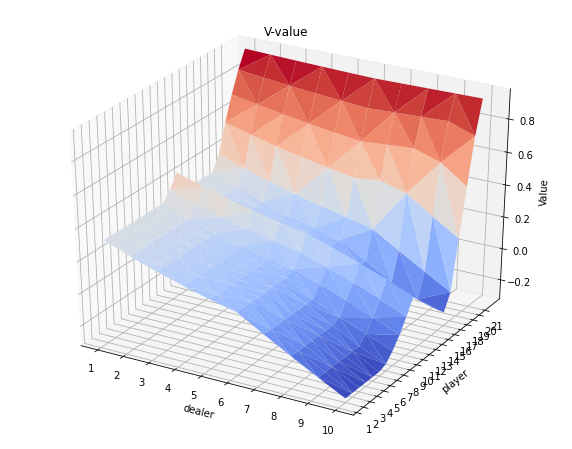

In [11]:
V_dic = defaultdict(int)
for i in range(env.MAX_VALUE):
    for j in range(env.CARD_VALUE_MAX):
        state = (j + 1, i + 1)
        V_dic[state, 0] = V[i, j]
        V_dic[state, 1] = -1000
env.Visualizer.visualize(V_dic, 'V-value')

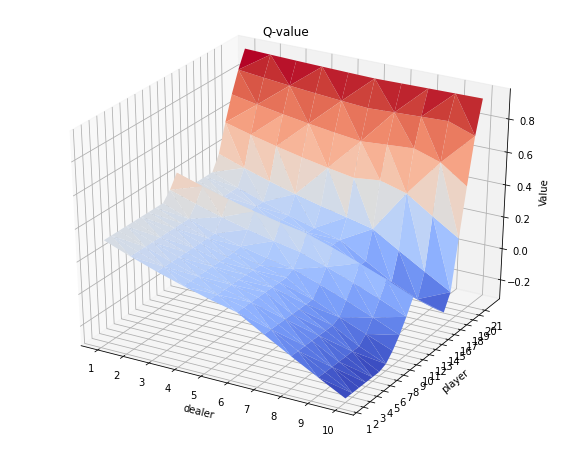

In [12]:
Q_dic = defaultdict(int)
Q_unshaped = R + np.matmul(P, V_unshaped)
Q_shaped = Q_unshaped.reshape(env.MAX_VALUE + 1 , env.CARD_VALUE_MAX + 1 , 2)

for i in range(1, env.MAX_VALUE + 1):
    for j in range(1, env.CARD_VALUE_MAX + 1):
        state = (j, i)
        Q_dic[state, 0] = Q_shaped[i, j, 0]
        Q_dic[state, 1] = Q_shaped[i, j, 1]
env.Visualizer.visualize(Q_dic, 'Q-value')

# Policy Iteration

In [13]:
def policy_improvement(val):
    Q = R + np.matmul(P, val)
    return np.argmax(Q, axis=-1)

def policy_evaluation(policy, pdim, ddim, v0 = None):
    val = v0
    if v0 is None:
        val = np.zeros((pdim * ddim))
    rows = np.arange(len(val))
    for epoch in range(100):
        temp = R[rows, policy] + np.matmul(P[rows, policy], val)
        diff = np.max(np.abs(val - temp))
        print('\tPolcyEvaluation epoch #%d\tdiff: %.7f' %(epoch + 1, diff))
        val = temp
        if diff < 1e-5:
            break
    return val

def policy_iteration(pdim, ddim):
    Vpi = np.zeros((pdim * ddim))
    for epoch in range(100):
        policy = policy_improvement(Vpi)
        Vtemp = policy_evaluation(policy, pdim, ddim, v0 = Vpi)
        diff = np.max(np.abs(Vtemp - Vpi))
        print('PolicyIteration epoch #%d\tdiff: %.7f' %(epoch + 1, diff))
        Vpi = Vtemp
        if diff < 1e-9:
            print('PolicyIteration is converged')
            break        
        print()
    return Vpi, Vpi.reshape((pdim, ddim))[1:, 1:], policy.reshape((pdim, ddim))[1:, 1:]

Vpi_unshaped, Vpi, policy = policy_iteration(env.MAX_VALUE + 1, env.CARD_VALUE_MAX + 1)

	PolcyEvaluation epoch #1	diff: 0.9536395
	PolcyEvaluation epoch #2	diff: 0.1752320
	PolcyEvaluation epoch #3	diff: 0.0417986
	PolcyEvaluation epoch #4	diff: 0.0111613
	PolcyEvaluation epoch #5	diff: 0.0066336
	PolcyEvaluation epoch #6	diff: 0.0036140
	PolcyEvaluation epoch #7	diff: 0.0020082
	PolcyEvaluation epoch #8	diff: 0.0011135
	PolcyEvaluation epoch #9	diff: 0.0006176
	PolcyEvaluation epoch #10	diff: 0.0003425
	PolcyEvaluation epoch #11	diff: 0.0001899
	PolcyEvaluation epoch #12	diff: 0.0001053
	PolcyEvaluation epoch #13	diff: 0.0000584
	PolcyEvaluation epoch #14	diff: 0.0000324
	PolcyEvaluation epoch #15	diff: 0.0000180
	PolcyEvaluation epoch #16	diff: 0.0000100
PolicyIteration epoch #1	diff: 0.9536395

	PolcyEvaluation epoch #1	diff: 0.1696749
	PolcyEvaluation epoch #2	diff: 0.0236988
	PolcyEvaluation epoch #3	diff: 0.0062860
	PolcyEvaluation epoch #4	diff: 0.0023059
	PolcyEvaluation epoch #5	diff: 0.0008869
	PolcyEvaluation epoch #6	diff: 0.0003399
	PolcyEvaluation epoch #7	d

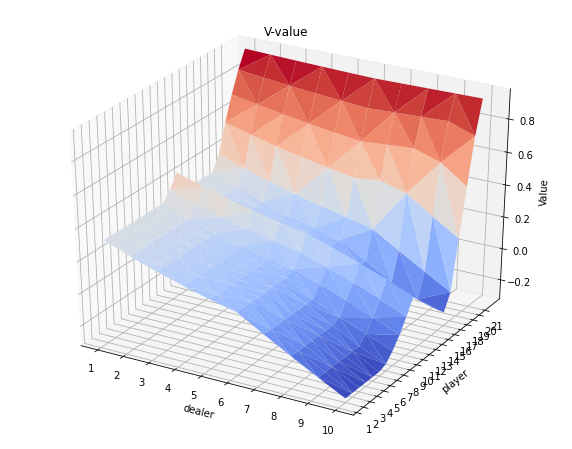

In [14]:
V_dic = defaultdict(int)
for i in range(env.MAX_VALUE):
    for j in range(env.CARD_VALUE_MAX):
        state = (j + 1, i + 1)
        V_dic[state, 0] = Vpi[i, j]
        V_dic[state, 1] = -1000
env.Visualizer.visualize(V_dic, 'V-value')

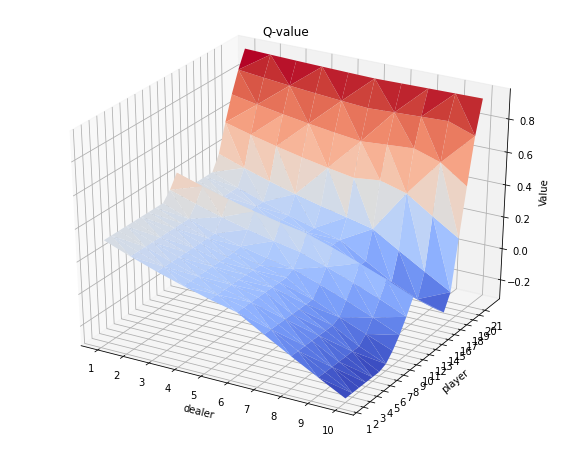

In [15]:
Q_dic = defaultdict(int)
Q_unshaped = R + np.matmul(P, Vpi_unshaped)
Q_shaped = Q_unshaped.reshape(env.MAX_VALUE + 1 , env.CARD_VALUE_MAX + 1 , 2)

for i in range(1, env.MAX_VALUE + 1):
    for j in range(1, env.CARD_VALUE_MAX + 1):
        state = (j, i)
        Q_dic[state, 0] = Q_shaped[i, j, 0]
        Q_dic[state, 1] = Q_shaped[i, j, 1]
env.Visualizer.visualize(Q_dic, 'Q-value')

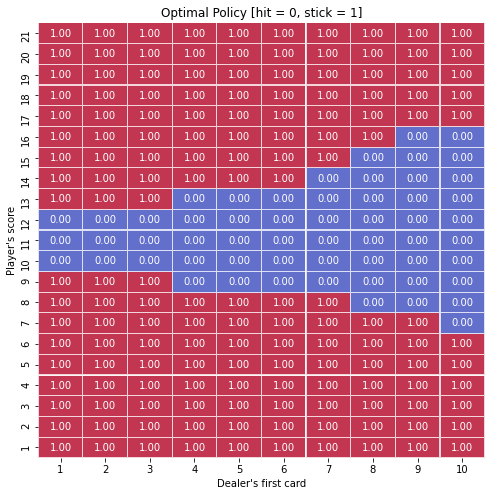

In [16]:
env.Visualizer.draw2d_array(policy, 'Optimal Policy [hit = 0, stick = 1]', True)